In [165]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()

### Data Preprocessing

In this dataset, we have to consider which of the factors may play a role in someone exiting a bank. To do that we must look at all the column and infer whether it will matter in classifying a new customer or not. The information about a customer is entailed in columns 0 through 12 (RowNumber-EstimatedSalary), while the output (whether the customer exited or not) is stored in the 13th row (Exited).

For as much as we care, neither the customer ID, nor the surname should matter in classification. Therefore, we will use columns 3 (CreditScore) inclusive through the 13th column (exclusive).

In [166]:
#importing the dataset
dataset = pd.read_csv('./Churn_Modelling.csv', index_col='RowNumber')
dataset.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [167]:
X_columns = dataset.columns.tolist()[2:12]
y_columns = dataset.columns.tolist()[-1:]
print(f'All columns: {dataset.columns.tolist()}')
print()
print(f'X values: {X_columns}')
print()
print(f'y values: {y_columns}')

All columns: ['CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']

X values: ['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']

y values: ['Exited']


In [168]:
X = dataset[X_columns].values # Credit Score through Estimated Salary
y = dataset[y_columns].values # Exited

In [169]:
# Encoding categorical (string based) data. Country: there are 3 options: France, Spain and Germany
# This will convert those strings into scalar values for analysis
print(X[:8,1], '... will now become: ')
from sklearn.preprocessing import LabelEncoder
label_X_country_encoder = LabelEncoder()
X[:,1] = label_X_country_encoder.fit_transform(X[:,1])
print(X[:8,1])

['France' 'Spain' 'France' 'France' 'Spain' 'Spain' 'France' 'Germany'] ... will now become: 
[0 2 0 0 2 2 0 1]


In [170]:
# We will do the same thing for gender. this will be binary in this dataset
print(X[:6,2], '... will now become: ')
from sklearn.preprocessing import LabelEncoder
label_X_gender_encoder = LabelEncoder()
X[:,2] = label_X_gender_encoder.fit_transform(X[:,2])
print(X[:6,2])

['Female' 'Female' 'Female' 'Female' 'Female' 'Male'] ... will now become: 
[0 0 0 0 0 1]


The Problem here is that we are treating the countries as one variable with ordinal values (0 < 1 <  2). Therefore, one way to get rid of that problem is to split the countries into respective dimensions. 


You can now see that the first three columns represent the three countries that constituted the "country" category. We can now observe that  we essentially only need two columns: a 0 on two countries means that the country has to be the one variable which wasn't included. This will save us from the problem of using too many dimensions.


We have achieved this using the `drop='first'` option in the OneHotEncoder

Feature scaling is a method used to standardize the range of independent variables or features of data. It is basically scaling all the dimensions to be even so that one independent variable does not dominate another. For example, bank account balance ranges from millions to 0, whereas gender is either 0 or 1. If one of the features has a broad range of values, the distance will be governed by this particular feature. Therefore, the range of all features should be normalized so that each feature contributes approximately proportionately to the final distance.

In [171]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


pipeline = Pipeline(
    [('Categorizer', ColumnTransformer(
         [ # Gender
          ("Gender Label encoder", OneHotEncoder(categories='auto', drop='first'), [2]),
           # Geography
          ("Geography One Hot", OneHotEncoder(categories='auto', drop='first'), [1])
         ], remainder='passthrough', n_jobs=1)),
     # Standard Scaler for the classifier
    ('Normalizer', StandardScaler())
    ])

In [172]:
X = pipeline.fit_transform(X)

In [173]:
# Splitting the dataset into the Training and Testing set.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 0)

In [174]:
print(f'training shapes: {X_train.shape}, {y_train.shape}')
print(f'testing shapes: {X_test.shape}, {y_test.shape}')

training shapes: (8000, 11), (8000, 1)
testing shapes: (2000, 11), (2000, 1)


### End of Preprocessing

Making the NN

In [175]:

from keras.models import Sequential
from keras.layers import Dense, Dropout

In [176]:
classifier = Sequential()

In [177]:
classifier.add(Dense(6, activation = 'relu', input_shape = (X_train.shape[1], )))
classifier.add(Dropout(rate=0.1)) 

We are going to add another layer to this model because we want to implement Deep Learning, which is an artificial Neural network with many layers.
We will make our second hidden layer also have 6 nodes, just playing with the same arithmetic we used to determine the dimensions of the first hidden layer (average of your input and output layers)  (11+1)÷2=6 .

In [178]:
# Adding the second hidden layer
# Notice that we do not need to specify input dim. 
classifier.add(Dense(6, activation = 'relu')) 
classifier.add(Dropout(rate=0.1)) 

#### Adding the output layer


The breakdown of the inputs for the output layer is as follows:
activiation: sigmoid becasue we are in an output layer. uses the Sigmoid activation function for  𝜙 . This is used instead of the ReLu function becasue it generates probabilities for the outcome. We want the probability that each customer leaves the bank.

units: 6 nodes (number of nodes in hidden layer). Can think of this as number of nodes are in the next layer.

input_dim: 11 because we span 11 dimensions in our input layer. This is needed for the first added layer. The subsequent layers's input dimensions can be inferred using the previously added layer's output dimension. The next hidden layer will know what to expect.

In [179]:
# Adding the output layer
# Notice that we do not need to specify input dim. 
# we have an output of 1 node, which is the the desired dimensions of our output (stay with the bank or not)
# We use the sigmoid because we want probability outcomes
classifier.add(Dense(1, activation = 'sigmoid')) 

If we want more than two categories, then we will need to change
1) the units parameter to match the desired category count

2) the activation field to softmax. Basically a sigmoid function but applied to a dependent variable that has more than 2 categories.

In [180]:
classifier.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 6)                 72        
                                                                 
 dropout_6 (Dropout)         (None, 6)                 0         
                                                                 
 dense_9 (Dense)             (None, 6)                 42        
                                                                 
 dropout_7 (Dropout)         (None, 6)                 0         
                                                                 
 dense_10 (Dense)            (None, 1)                 7         
                                                                 
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


Basically applying Stochastic Gradient descent on the whole Neural Network. We are Tuning the individual weights on each neuron.

The breakdown of the inputs for compiling is as follows:


`optimizer`: adam The algorithm we want to use to find the optimal set of weights in the neural networks. Adam is a very efficeint variation of Stochastic Gradient Descent.

`loss`: binary_crossentropy This is the loss function used within adam. This should be the logarthmic loss. If our dependent (output variable) is Binary, it is binary_crossentropy. If Categorical, then it is called categorical_crossentropy

`metrics`: [accuracy] The accuracy metrics which will be evaluated(minimized) by the model. Used as accuracy criteria to imporve model performance.

In [181]:
classifier.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])

### Fitting the Neural Network

The breakdown of the inputs for compiling is as follows:

`X_train`: The independent variable portion of the data which needs to be fitted with the model.

`Y_train`: The output portion of the data which the model needs to produce after fitting.

`batch_size`: How often we want to back-propogate the error values so that individual node weights can be adjusted.

`epochs`: The number of times we want to run the entire test data over again to tune the weights. This is like the fuel of the algorithm.

`validation_split`: 0.2 The fraction of data to use for validation data.

In [182]:
history = classifier.fit(X_train, y_train, batch_size=32, epochs=200, validation_split=0.1, verbose=2)

Epoch 1/200
225/225 - 0s - loss: 0.5536 - accuracy: 0.7804 - val_loss: 0.4847 - val_accuracy: 0.7950 - 457ms/epoch - 2ms/step
Epoch 2/200
225/225 - 0s - loss: 0.4943 - accuracy: 0.7946 - val_loss: 0.4500 - val_accuracy: 0.7950 - 93ms/epoch - 412us/step
Epoch 3/200
225/225 - 0s - loss: 0.4724 - accuracy: 0.7961 - val_loss: 0.4327 - val_accuracy: 0.7950 - 93ms/epoch - 415us/step
Epoch 4/200
225/225 - 0s - loss: 0.4556 - accuracy: 0.7960 - val_loss: 0.4221 - val_accuracy: 0.7950 - 92ms/epoch - 408us/step
Epoch 5/200
225/225 - 0s - loss: 0.4479 - accuracy: 0.7968 - val_loss: 0.4139 - val_accuracy: 0.7962 - 92ms/epoch - 410us/step
Epoch 6/200
225/225 - 0s - loss: 0.4424 - accuracy: 0.8025 - val_loss: 0.4063 - val_accuracy: 0.8112 - 90ms/epoch - 402us/step
Epoch 7/200
225/225 - 0s - loss: 0.4342 - accuracy: 0.8071 - val_loss: 0.3999 - val_accuracy: 0.8188 - 98ms/epoch - 435us/step
Epoch 8/200
225/225 - 0s - loss: 0.4268 - accuracy: 0.8107 - val_loss: 0.3951 - val_accuracy: 0.8225 - 91ms/epoc

### Testing the NN

Predicting the Test set results

This shows the probability of a customer leaving given the testing data. Each row in X_test corresponds to a row in Y_test

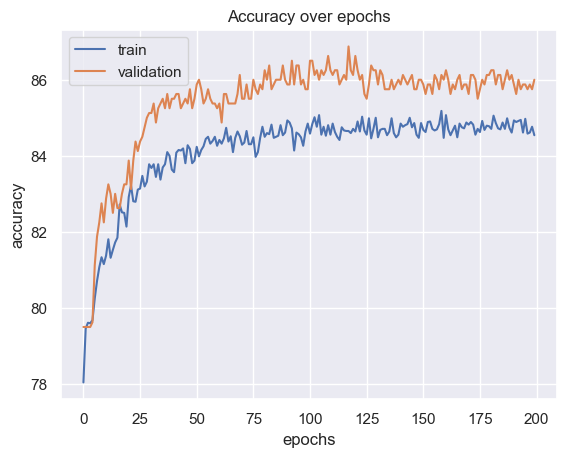

In [194]:
plt.plot(np.array(history.history['accuracy']) * 100)
plt.plot(np.array(history.history['val_accuracy']) * 100)
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'validation'])
plt.title('Accuracy over epochs')
plt.show()

In [195]:
y_pred = classifier.predict(X_test)
print(y_pred[:5])

63/63 [==============================] - 0s 439us/step
[[0.32259375]
 [0.26304004]
 [0.1800081 ]
 [0.06218624]
 [0.10129685]]


To use the confusion Matrix, we need to convert the probabilities that a customer will leave the bank into the form true or false. So we will use the cutoff value 0.5 to indicate whether they are likely to exit or not.

In [196]:
y_pred = (y_pred > 0.5).astype(int)
print(y_pred[:5])

[[0]
 [0]
 [0]
 [0]
 [0]]


Making the Confusion Matrix

In [197]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[1556   39]
 [ 231  174]]


In [198]:
print (((cm[0][0]+cm[1][1])*100)/(len(y_test)), '% of testing data was classified correctly')

86.5 % of testing data was classified correctly
